In [545]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import fastsparsegams
import time
import pandas as pd

### Define DGP

#### Define DGP functions

In [546]:
class DGP: 
    #Returns X_aug, X_indicator, y
    #no intercept augmentation of dataset because the model has an automatic intercept. 
    def data_gen(self, **kwargs):
        return "Not Yet Implemented - We expect children to implement a data generation process."
    
    #give P(Y=1) for each observation (row) in X
    def estimate_true_probs(self, X, n = 1000, verbose=True, **kwargs): 
        #default behaviour: estimate empirically from DGP
        X_interaction, X_indicator, y = self.data_gen(n=n)
        
        sample_X = X_interaction
        if X_interaction.shape[1] != X.shape[1]: 
            if X_indicator.shape[1] != X.shape[1]: 
                print("ERROR! not the right shape")
            else: 
                sample_X = X_indicator
        
        true_probs = np.ones(X.shape[0])
        for i, row in enumerate(X): 
            #if the observation was seen at least once in the sample, 
            # use the empirical distribution to estimate the true probability
            if (sample_X == X).all(axis=1).any(): 
                true_probs[i] = y[(sample_X == X).all(axis=1)].mean()
            else: 
                #otherwise print an error and use a less precise estimate: 
                true_probs[i] = y.mean()
                if verbose: 
                    print("Observation ", row, "was not found in the generated sample,", 
                          "so probability was estimated based on all points.",
                          "Possible solutions might be: increasing the number of samples,", 
                          "using a closed form for this case instead of an empirical estimate,",
                         "modifying this (inherited) function to encode some independence assumptions",
                          "(like encoding the independence between y and a variable that is just noise),",
                         "or reducing the number of variables in the DGP so that exact matches are more likely.")
        return true_probs
    
    def true_probs(self, X, verbose=True, **kwargs): 
        if verbose: 
            print('Closed form not encoded; approximating with empirical estimate')
        return self.estimate_true_probs(X, verbose=verbose) #may want to pass along kwargs as well
        

In [547]:
class MCAR_noisy_recovery(DGP): 
    def __init__(self, n_vars=3): 
        self.n_vars = n_vars
        
    def data_gen(self, n=10000, correlation_prop = 0.85, missingness_prop = 0.4, seed = None): 
        if self.n_vars < 2: 
            print('not enough variables!')
            return -1, -1, -1, -1

        if seed is not None: 
            np.random.seed(seed)

        X = np.random.choice([True, False], (n,self.n_vars+1))

        #with rate correlation_prop, X_:0 is equal to X_:1
        correlation_indices = np.random.permutation(n)[:int(correlation_prop*n)]
        X[correlation_indices, 0] = X[correlation_indices, 1]

        #Y is always X_:0
        y = np.copy(X[:, 0])

        #X_:0 is sometimes missing
        missing_indices = np.random.permutation(n)[:int(missingness_prop*n)]
        X[missing_indices, 0] = False
        #last column X_:-1 is missingness indicator for X_:0
        X[:, -1] = False
        X[missing_indices, -1] = True

        #create augmented matrix (add interaction terms): 
        X_aug = np.concatenate([X, np.logical_and(X[:, -1].reshape(-1, 1), X[:, 1:-1])], axis=1)

        return X_aug, X, y
    
    def true_probs(self, X): 
        true_probs = np.zeros(X.shape[0])
        
        # if X_.0 is true, then y is 100% true
        true_probs[X[:, 0]] = 1
        
        # if X_.0 is missing (indicator is X_.[nvars]), then we base probabilities off of X_.1
        true_probs[X[:, self.n_vars]] = X[:, 1][X[:, self.n_vars]].astype(float) * 0.85 + 0.075
        
        #else y is 0% true (as covered by initialization with np.zeros)
        
        return true_probs

In [548]:
class MNAR_logical(DGP): #Y_. = X_.1 OR (indicator X_.0 is missing)
    def __init__(self, n_vars=3, operation= 'or', negation = False): 
        self.n_vars = n_vars
        self.negation = negation
        self.operation = operation.lower()
        if self.operation not in ['or', 'and', 'xor']: 
            print("ERROR! operation must be 'or', 'and', or 'xor'")
        
    def data_gen(self, n=10000, missingness_prop = 0.4, seed = None): 
        if self.n_vars < 2: 
            print('not enough variables!')
            return -1, -1, -1, -1

        if seed is not None: 
            np.random.seed(seed)

        X = np.random.choice([True, False], (n,self.n_vars+1))

        #X_:0 is sometimes missing
        missing_indices = np.random.permutation(n)[:int(missingness_prop*n)]
        X[missing_indices, 0] = False
        #last column X_:-1 is missingness indicator for X_:0
        X[:, -1] = False
        X[missing_indices, -1] = True

        #Y is always X_.1 [logical operator] indicator X_.0 is missing
        y = (np.logical_or(X[:, -1], X[:, 1]) if self.operation == 'or' 
             else np.logical_and(X[:, -1], X[:, 1]) if self.operation == 'and' 
             else np.logical_xor(X[:, -1], X[:, 1]))
        if self.negation: 
            y = np.logical_not(y)

        #create augmented matrix (add interaction terms): 
        X_aug = np.concatenate([X, np.logical_and(X[:, -1].reshape(-1, 1), X[:, 1:-1])], axis=1)

        return X_aug, X, y
    
    def true_probs(self, X): 
        #Y is always X_.1 [logical operator] indicator X_.0 is missing
        true_probs = (np.logical_or(X[:, self.n_vars], X[:, 1]) if self.operation == 'or' 
             else np.logical_and(X[:, self.n_vars], X[:, 1]) if self.operation == 'and' 
             else np.logical_xor(X[:, self.n_vars], X[:, 1]))
        
        return true_probs if not self.negation else 1 - true_probs

In [550]:
class MNAR_arbitrary_op(DGP): #run any operation on X_:0's missingness indicator and X_:1, adding optional noise
    def __init__(self, n_vars=3, y_noise = 0, x_noise = 0, operation = lambda mi, x1: np.logical_or(mi, x1)): 
        self.n_vars = n_vars
        self.operation = operation
        self.y_noise = y_noise
        if y_noise > 1 or y_noise < 0: 
            print("Error! Noise must be between 0 and 1, inclusive.")
        if np.shape(x_noise) == (): 
            x_noise = np.ones(n_vars+1) * x_noise #todo: make missingness noise a separate argument? 
        elif np.shape(x_noise) != (n_vars+1,): 
            print("Error! x_noise must be a scalar or an array of length n_vars+1 (last entry is noise for missingness).")
        self.x_noise = x_noise
        
    def data_gen(self, n=10000, missingness_prop = 0.4, seed = None): 
        if self.n_vars < 2: 
            print('not enough variables!')
            return -1, -1, -1, -1

        if seed is not None: 
            np.random.seed(seed)

        X = np.random.choice([True, False], (n,self.n_vars+1))

        #X_:0 is sometimes missing
        missing_indices = np.random.permutation(n)[:int(missingness_prop*n)]
        X[missing_indices, 0] = False
        #last column X_:-1 is missingness indicator for X_:0
        X[:, -1] = False
        X[missing_indices, -1] = True

        #Y is always X_.1 [logical operator] indicator X_.0 is missing
        y = self.operation(X[:, -1], X[:, 1])

        #noising: swap some 0 and 1 values in y: 
        y_noise_indices = np.random.permutation(n)[:int(self.y_noise*n)]
        y[y_noise_indices] = np.logical_not(y[y_noise_indices])

        for i in range(len(self.x_noise)): 
            x_noise_indices = np.random.permutation(n)[:int(self.x_noise[i]*n)]
            X[x_noise_indices, i] = np.logical_not(X[x_noise_indices, i])

        #create augmented matrix (add interaction terms): 
        X_aug = np.concatenate([X, np.logical_and(X[:, -1].reshape(-1, 1), X[:, 1:-1])], axis=1)

        return X_aug, X, y
    
    def true_probs(self, X):

        true_probs = np.zeros(X.shape[0])
        #Y is always X_.1 [logical operator] indicator X_.0 is missing

        #Split into cases, with corresponding probabilities: 
        # Case 1: neither feature is flipped: 
        true_probs += self.operation(X[:, self.n_vars], X[:, 1]) * (1 - self.x_noise[1]) * (1 - self.x_noise[self.n_vars])
        # only X_:1 is flipped:
        true_probs += self.operation(X[:, self.n_vars], np.logical_not(X[:, 1])) * (self.x_noise[1]) * (1 - self.x_noise[self.n_vars])
        # only missingness indicator is flipped:
        true_probs += self.operation(np.logical_not(X[:, self.n_vars]), (X[:, 1])) * (1 - self.x_noise[1]) * (self.x_noise[self.n_vars])
        # both are flipped:
        true_probs += self.operation(np.logical_not(X[:, self.n_vars]), np.logical_not(X[:, 1])) * (self.x_noise[1]) * (self.x_noise[self.n_vars])

        # account for the noising of the label: 
        true_probs = (1 - self.y_noise) * true_probs + self.y_noise * (1 - true_probs)
        
        return true_probs

#### Select DGP

In [551]:
dgp = MCAR_noisy_recovery(n_vars=3)#MNAR_arbitrary_op(n_vars=3, y_noise = 0.0, x_noise = 0.05, operation = lambda mi, x1: np.logical_or(mi, x1))

### Generate train/test data

In [552]:
X_aug_train, X_indicator_train, y_train = dgp.data_gen(seed=1000)
X_aug_test, X_indicator_test, y_test = dgp.data_gen(seed=1001)

### Fit on data with interactions (augmented data)

In [553]:
model_aug = fastsparsegams.fit(
    X_aug_train.astype(float), y_train.astype(int)*2 - 1, loss="Exponential", max_support_size=20, algorithm="CDPSI"
)

### Fit on indicator-only data

In [554]:
model_indicator = fastsparsegams.fit(
    X_indicator_train.astype(float), y_train.astype(int)*2 - 1, loss="Exponential", max_support_size=20, algorithm="CDPSI"
)

#### Define model evaluation helper

In [555]:
#recover coefficients and train/test probabilities
def eval_model(model, X_train, X_test): 
    coeffs = np.zeros((len(model.lambda_0[0]), X_train.shape[1]))
    train_probs = np.zeros((len(model.lambda_0[0]), X_train.shape[0]))
    test_probs = np.zeros((len(model.lambda_0[0]), X_train.shape[0]))

    for i, lamby in enumerate(model.lambda_0[0]): 
        train_probs[i] = model.predict(X_train.astype(float),lambda_0=lamby).reshape(-1)
        test_probs[i] = model.predict(X_test.astype(float),lambda_0=lamby).reshape(-1)

        coeffs[i] = (model.coeff(lambda_0=lamby).toarray().flatten())[1:] #first entry is intercept
    return train_probs, test_probs, coeffs

#### Eval models

In [556]:
train_probs_aug, test_probs_aug, coeff_aug = eval_model(model_aug, X_aug_train, X_aug_test)

In [557]:
trainacc_aug = ((train_probs_aug > 0.5) == y_train).mean(axis = 1)
testacc_aug = ((test_probs_aug > 0.5) == y_test).mean(axis = 1)
num_terms_aug = (coeff_aug != 0).sum(axis=1)

In [558]:
train_probs_indicator, test_probs_indicator, coeff_indicator = eval_model(model_indicator, X_indicator_train, X_indicator_test)

In [559]:
trainacc_indicator = ((train_probs_indicator > 0.5) == y_train).mean(axis=1)

In [560]:
testacc_indicator = ((test_probs_indicator > 0.5) == y_test).mean(axis=1)

In [561]:
num_terms_indicator = (coeff_indicator != 0).sum(axis=1)

### Plot of basic accuracy/sparsity results

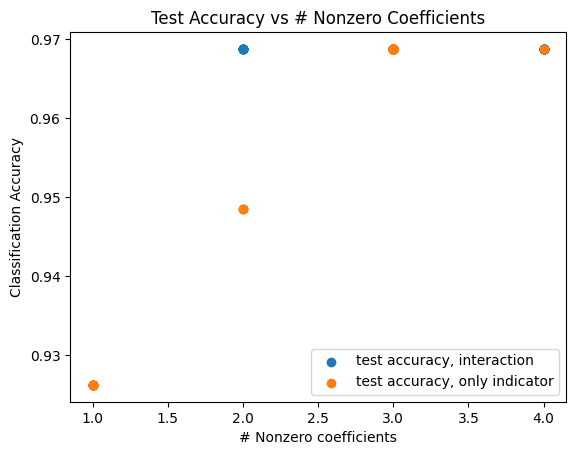

In [562]:
plt.title('Test Accuracy vs # Nonzero Coefficients')#\n (Other than intercept)
plt.scatter(num_terms_aug[num_terms_aug > 0], testacc_aug[num_terms_aug > 0], label='test accuracy, interaction')
plt.scatter(num_terms_indicator[num_terms_indicator > 0], testacc_indicator[num_terms_indicator > 0], label='test accuracy, only indicator')
plt.ylabel('Classification Accuracy')
plt.xlabel('# Nonzero coefficients')

plt.legend()

# Calibration, Objective, etc

In [563]:
true = dgp.true_probs(X_aug_train)
true_test = dgp.true_probs(X_aug_test)

In [564]:
calibration_no_interaction = np.linalg.norm(train_probs_indicator - true, axis=1)
calibration_interaction = np.linalg.norm(train_probs_aug - true, axis=1)

calibration_no_interaction_test = np.linalg.norm(test_probs_indicator - true_test, axis=1)
calibration_interaction_test = np.linalg.norm(test_probs_aug - true_test, axis=1)

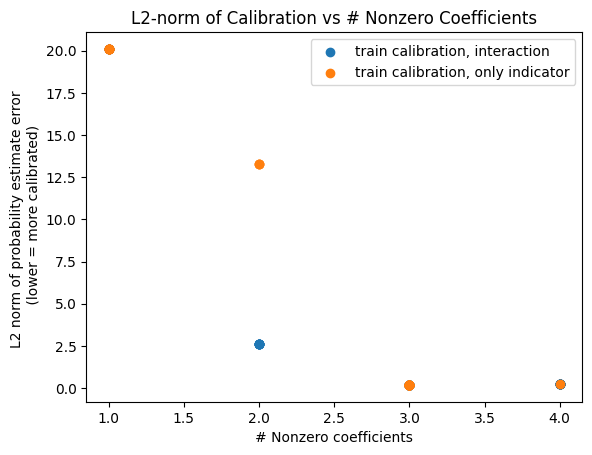

In [565]:
plt.title('L2-norm of Calibration vs # Nonzero Coefficients')#\n (Other than intercept)
plt.scatter(num_terms_aug[num_terms_aug > 0], calibration_interaction[num_terms_aug > 0], label='train calibration, interaction')
plt.scatter(num_terms_indicator[num_terms_indicator > 0], calibration_no_interaction[num_terms_indicator > 0], label='train calibration, only indicator')
# plt.plot(num_terms_aug[num_terms_aug > 0], calibration_interaction_test[num_terms_aug > 0], label='test calibration, interaction')
# plt.plot(num_terms_indicator[num_terms_indicator > 0], calibration_no_interaction_test[num_terms_indicator > 0], label='test calibration, only indicator')
plt.ylabel('L2 norm of probability estimate error \n (lower = more calibrated)')
plt.xlabel('# Nonzero coefficients')

plt.legend()

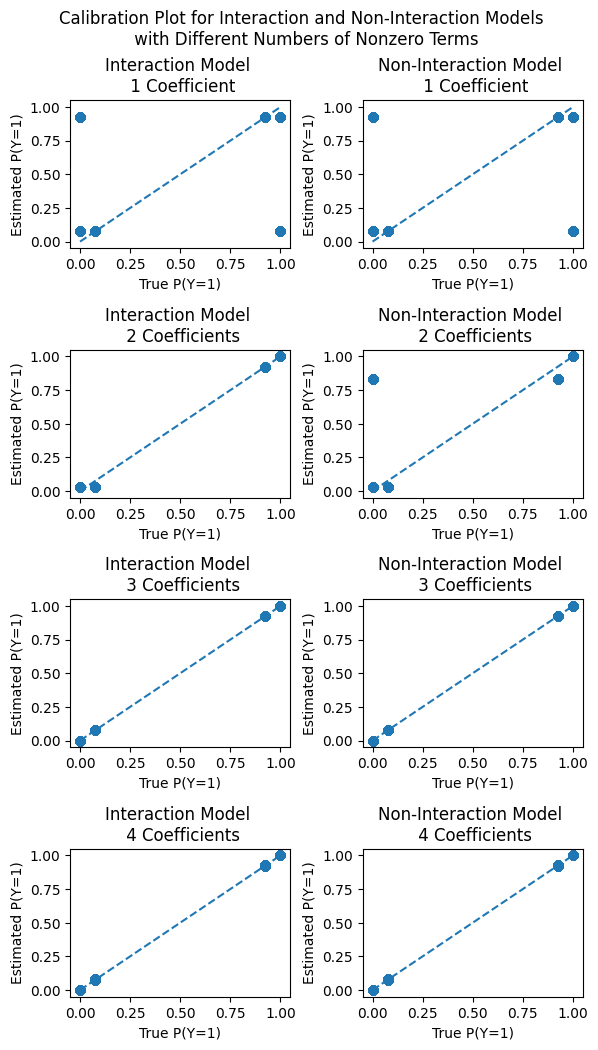

In [566]:
fig, axs = plt.subplots(num_terms_aug[-1], 2, figsize=(6,8/3*num_terms_aug[-1]))

plt.suptitle("Calibration Plot for Interaction and Non-Interaction Models \n with Different Numbers of Nonzero Terms")

for num_coef in range(1, num_terms_aug[-1]+1): 
    if num_coef in num_terms_aug: 
        axs[num_coef-1, 0].scatter(true, train_probs_aug[num_terms_aug == num_coef, :][0])
        axs[num_coef-1, 0].plot([0, 1], [0, 1], linestyle='dashed', label='line of perfect calibration')
        axs[num_coef-1, 0].set_title('Interaction Model \n %d Coefficient'%num_coef + 
                                 ('s' if num_coef != 1 else ''))
        axs[num_coef-1, 0].set_xlabel('True P(Y=1)')
        axs[num_coef-1, 0].set_ylabel('Estimated P(Y=1)')
    
    if num_coef in num_terms_indicator:
        axs[num_coef-1, 1].scatter(true, train_probs_indicator[num_terms_indicator == num_coef, :][0])
        axs[num_coef-1, 1].plot([0, 1], [0, 1], linestyle='dashed', label='line of perfect calibration')
        axs[num_coef-1, 1].set_title('Non-Interaction Model \n %d Coefficient'%num_coef + 
                                 ('s' if num_coef != 1 else ''))
        axs[num_coef-1, 1].set_xlabel('True P(Y=1)')
        axs[num_coef-1, 1].set_ylabel('Estimated P(Y=1)')

fig.tight_layout()

#todo - get label of dashed calibration line to show up (once and only once) in a common legend

### Recover objective from prediction probability

In [567]:
def objective(probs, y): 
    return np.exp(np.log(probs/(1 - probs))*-1/2*y).sum(axis=1)

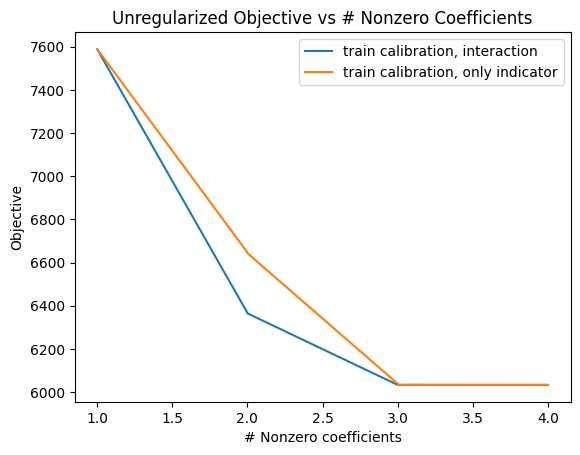

In [568]:
plt.title('Unregularized Objective vs # Nonzero Coefficients')#\n (Other than intercept)
plt.plot(num_terms_aug[num_terms_aug > 0], objective(train_probs_aug, y_train)[num_terms_aug > 0], label='train calibration, interaction')
plt.plot(num_terms_indicator[num_terms_indicator > 0], objective(train_probs_indicator, y_train)[num_terms_indicator > 0], label='train calibration, only indicator')
# plt.plot(num_terms_aug[num_terms_aug > 0], objective(test_probs_aug, y_train)[num_terms_aug > 0], label='test objective, interaction')
# plt.plot(num_terms_indicator[num_terms_indicator > 0], objective(test_probs_indicator, y_train)[num_terms_indicator > 0], label='test objective, only indicator')
plt.ylabel('Objective')
plt.xlabel('# Nonzero coefficients')

plt.legend()

In [569]:
coeff_aug[70]

array([14.71824705,  2.47388453,  0.        ,  7.57595471,  0.        ,
        0.        ])

#### Runtime tests

In [570]:
# computes average training time of fastsparsegams on a given dataset, as well as 5th and 95th percentiles
# assumes X, y come in the same format as provided by the dgp (so includes processing to make the matrices the right type)
def estimate_runtime(X, y, num_trials=100): 

    times = []
    start = time.time()

    for i in range(num_trials): 
        model = fastsparsegams.fit(
            X.astype(float), y.astype(int)*2 - 1, loss="Exponential", max_support_size=20, algorithm="CDPSI"
        )
        times.append(time.time())
    
    times = [cur - prev for cur, prev in zip(times, [start] + times[:-1])] #compute elapsed time for each trial

    return (np.mean(times), np.quantile(times, 0.05), np.quantile(times, 0.95))

    


In [571]:
# models_to_test = [MCAR_noisy_recovery(n_vars=3), MCAR_noisy_recovery(n_vars=30)]
# model_labels = ['MCAR_noisy_recovery_3vars', 'MCAR_noisy_recovery_30vars']
# bins = np.arange(len(model_labels))

In [572]:
# aug_times = np.zeros((3, len(models_to_test)))
# indicator_times = np.zeros((3, len(models_to_test)))
# for i, dgp in enumerate(models_to_test):
#     X_aug_train, X_indicator_train, y_train = dgp.data_gen(seed=100) #note: may need to vary seed
    
#     aug_times[:, i] = estimate_runtime(X_aug_train, y_train, num_trials=10)
#     indicator_times[:, i] = estimate_runtime(X_indicator_train, y_train, num_trials=10)

In [573]:
# plt.bar(bins, aug_times[0, :], 0.35, label='interaction', yerr=np.abs(aug_times[0, :] - aug_times[1:, :]))
# plt.bar(bins+0.35, indicator_times[0, :], 0.35, label='only indicator', yerr=np.abs(indicator_times[0, :] - indicator_times[1:, :]))
# plt.xticks(bins+0.175, model_labels)
# plt.ylabel('Average Training Time (seconds)')
# plt.legend()
# plt.title('Average Training Time for Interaction and Non-Interaction Models')